In [2]:
#Program Name: hw2.ipynb
#Date Created: September 29th, 2022
#Author: Deepesh Verma (dbv293)

In [3]:
#First Part of HW2 Assignment 
#Function: Solving of eigenvalue problem using the the power method. 
import numpy as np 
import matplotlib.pyplot as plt
import warnings
import scipy
%matplotlib inline

In [33]:
class powermethod: 
    """
    Implementation of the power method to solve the eignevalue problem. Stores the resulting vector as self.components_
    stores corresponding eigenvalues in self.singular_values_.

    Structure and naming derived from scikit-learn library:
    https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

    Parameters: 
        max_iter: maximum number of interations that can be performed. 
        tolerance: value for which fluctuations allowed in solution to break out early. 
        gamma: momentum parameter for power method. 
        random_state: seed for random number generator
        store_intermediate_results: true/false to store the intermediate results of the calculation as the power method
            iterates.
        stored_eigenvalues: if store_intermediate_results = true, eigenvalues are stored in a list at each interation.
        stored_eigenvector: if store_intermediate_results = true, eigenvectors are stored in a list at each iteration. 
    """
    def __init__(self,
        max_iter = 1000,
        tolerance = 1e-5,
        gamma = 0.0,
        random_state = None,
        store_intermediate_results = False
    ):
        """
        Initializes parameters for the power method calculation. 
        """
        #Sets parameters.
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.gamma = gamma
        self.random_state = random_state

        #Initializes placeholders for result of eigenvector and eigenvalue calculation. 
        self.singular_values_ = None
        self.components_ = None

        #Initiliazes placeholders for intermediate estimates of eigenvalue and eigenvector calculation.
        self.store_intermediate_results = store_intermediate_results
        if self.store_intermediate_results:
            self.stored_eigenvalues = list()
            self.stored_eigenvectors = list()

    def fit(self,A):
        """ 
        Performs the power method for a random initialized matrix A. Can optionally store the intermedaite estimates of 
        the leading eigenvalue and eigenvector calculation at each iteration. Calculation will end early if tolerance
        is reached. 
        """

        #Finds shape of matrix A and initializes a random vector vec. 
        n = A.shape[0]
        np.random.seed(self.random_state)
        vec = np.random.random(n)
        #Makes vec a unit vector.
        vec = vec/np.linalg.norm(vec)

        #Appends lists with initial value of eigenvalue and eigenvector calculations.
        if self.store_intermediate_results:
            self.stored_eigenvalues.append(1)
            self.stored_eigenvectors.append(vec)

        #Iterates the power method for max_iter.
        for i in range(self.max_iter):
            prev = np.copy(vec)
            vec = A.dot(vec)
            eig_val = np.linalg.norm(vec)
            vec = vec/eig_val

            #Momentum term representation of vec.
            #vec = self.gamma*prev + (1-self.gamma)*vec

            #Secondary improvement by updating gamma based on error signal. 
            #vec = (1-err)*prev + err*vec
            #err = np.sqrt((vec-prev)**2 / prev**2)

            #Appends lists with intermediate values of eigenvalue and eigenvector calculations.
            if self.store_intermediate_results:
                self.stored_eigenvalues.append(eig_val)
                self.stored_eigenvectors.append(vec)

            #Checks breaking condition (tolerance). 
            if np.mean(np.sqrt((vec - prev)**2 / prev**2)) < self.tolerance:
                warnings.warn(f"Power method converged before {self.max_iter} iterations")
                break
        
        #Turns lists for intermediate values of eigenvalues and eigenvector calculations into arrays.
        if self.store_intermediate_results:
            self.stored_eigenvalues = np.array(self.stored_eigenvalues)
            self.stored_eigenvectors = np.array(self.stored_eigenvectors)

        #Writes leading eigenvalue and corresponding eigenvector for output. 
        self.singular_values_ = eig_val
        self.components_ = vec

Power method solution: 3.4152296762494156
numpy solution: 0.5508226838344339


Text(0, 0.5, 'Power Method Eigenvector')

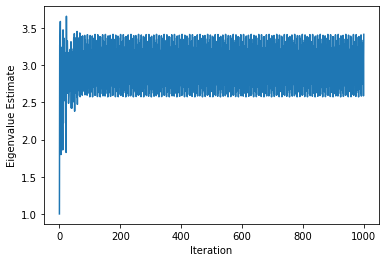

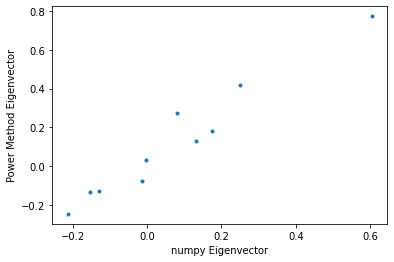

In [34]:
#Initializes random value for reproducibility.
np.random.seed(4)

#Initializes a matrix M. 
M = np.random.normal(size=(10, 10)) #fails to converge for np.random.seed(4)
#M = np.random.random(size=(10,10)) #does converge for np.random.seed(4)

#Uses our powermethod to find the eigenvalues and eigenvectors. Also stores intermediate values.
test = powermethod(store_intermediate_results=True)
test.fit(M);

#Uses numpy eigensystem solver to find the eigenvalues and eigenvectors. 
def eigmax_numpy(A):
    """
    Computes the maximum eigenvalue and corresponding eigenvector in a matrix using numpy.
    """
    eigsys = np.linalg.eig(A)
    ind = np.abs(eigsys[0]).argmax()
    return np.real(eigsys[0][ind]), np.real(eigsys[1][:, ind])

#Compares the leading eigenvalue calculated by the power method and numpy. 
print(f"Power method solution: {test.singular_values_}")
print(f"numpy solution: {eigmax_numpy(M)[0]}")

#Plot to show the progress of the power method towards determining the leading eigenvalue. 
plt.figure()
plt.plot(test.stored_eigenvalues)
plt.xlabel("Iteration")
plt.ylabel("Eigenvalue Estimate")

#Plot comparing the eigenvectors determined by the two methods. 
plt.figure()
plt.plot(eigmax_numpy(M)[1], test.components_, '.')
plt.xlabel("numpy Eigenvector")
plt.ylabel("Power Method Eigenvector")

In [6]:
#Second Part of HW2 Assignment 
#Function: Using principal component analysis (PCA) to represent high-dimensional data sets.
from sklearn.base import BaseEstimator, TransformerMixin

In [11]:
#Import Data. Not downloading multiple 2.3GB files, my laptop goes through enough already :'(
vfield = np.load(
    f"/Users/deepesh.b.verma/documents/grad/grad4/fall2022/phy381c/hw2/vortex_street_velocities_Re_1200_largefile.npz", 
    allow_pickle=True
)
print("Velocity field data has shape: {}".format(vfield.shape))

# Calculates the vorticity.
vort_field = np.diff(vfield, axis=1)[..., :-1, 1] + np.diff(vfield, axis=2)[:, :-1, :, 0] 


Velocity field data has shape: (3000, 256, 128, 2)


In [13]:
class pca(BaseEstimator,TransformerMixin):
    """
    Class object that performs the principal component analysis on a dataset to reduce the dimensionality. 
    For more information on the principal component analysis: https://en.wikipedia.org/wiki/Principal_component_analysis
    """
    def __init__(self,random_state=None):

        #Initializes parameters. 
        self.random_state = random_state
        self.components_ = None
        self.singular_values_ = None

    def fit(self,X):
        """
        Implementation of the PCA method for a data set X. Stores the eigenvectors in self.components_ and their
        corresponding eigenvalues in self.singular_values_.

        Parameters: 
            X (IN): 2D dataset, size = (n_samples,n_features), containing the data to be fit. 
            self (OUT): The fitted object due to the PCA method on dataset X. 
        """

        #Subtracts the mean vector from out dataset. 
        Xc = X - np.mean(X,axis=0)

        #Computation of the covariance matrix. 
        Cov = Xc.T.dot(Xc) / Xc.shape[0]

        #Computation of the eigenvectors using numpy. 
        S, V = np.linalg.eigh(Cov)
        V = V.T

        #Sorts eigenvalues in descending order. 
        sort_inds = np.argsort(S)[::-1]
        S, V = S[sort_inds], V[sort_inds]

        #Assigns V and S to result variables. 
        self.components_ = V
        self.singular_values_ = S

        return self

    def transform(self, X):
        """
        Transform the dataset matrix X into the new basis calculated by PCA method.
        """
        Xc = X - np.mean(X, axis=0)
        return Xc.dot(self.components_.T)

    def inverse_transform(self, X):
        """
        Transform from principal components space back to the original dataset space.
        """
        return X.dot(self.components_) + np.mean(X, axis=0)

In [24]:
#Test run of pca method.
#Cuts dataset down so doesn't take too long to do, still a while though. 
data = np.copy(vort_field)[::3, ::2, ::2]
data_reshaped = np.reshape(data, (data.shape[0], -1))

#Performs PCA method on data. 
model = pca()
data_transformed = model.fit(data_reshaped)
principal_components = np.reshape(
    model.components_, (model.components_.shape[0], data.shape[1], data.shape[2])
)

Text(0, 0.5, 'Eigenvalue rank')

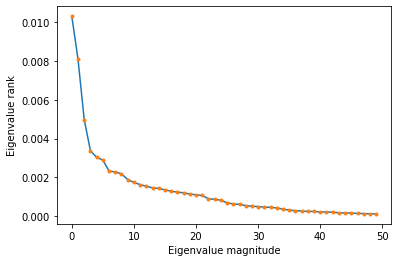

In [26]:
#Plot of how dominant eigenvalues of the dataset are. 
plt.figure()
plt.plot(model.singular_values_[:50])
plt.plot(model.singular_values_[:50], '.')
plt.xlabel("Eigenvalue magnitude")
plt.ylabel("Eigenvalue rank")

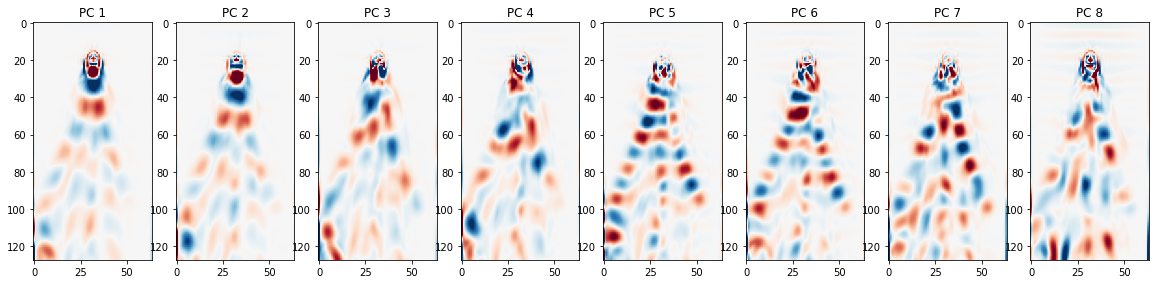

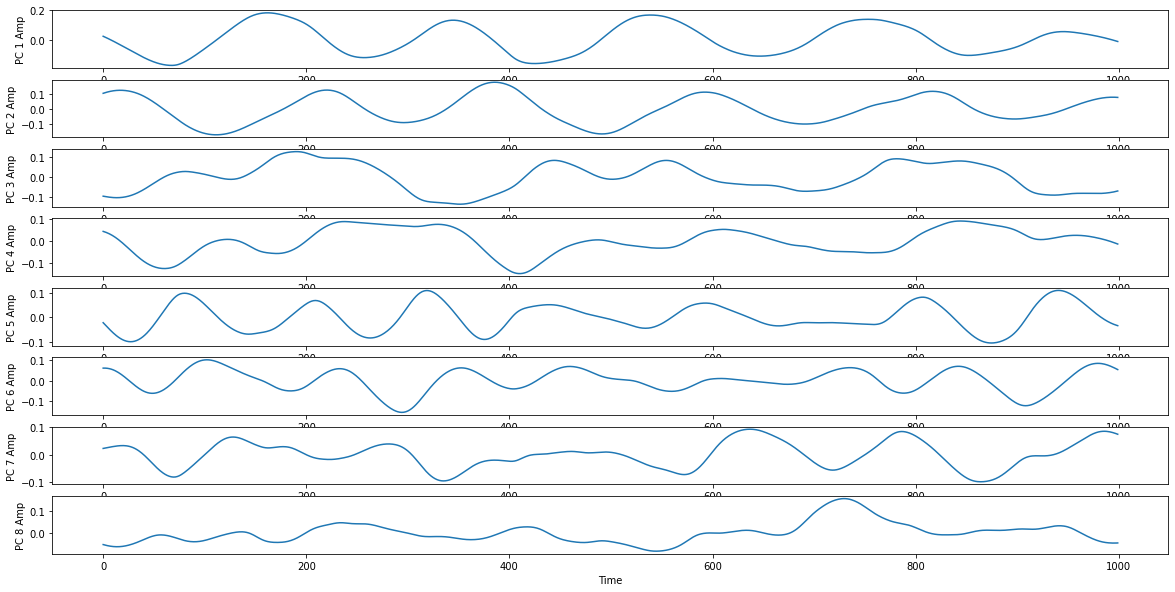

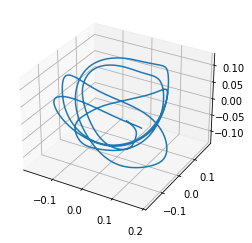

In [28]:
#No idea what this analysis is actually trying to display in terms of the physics insolved. 
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(1, 8, i+1)
    vscale = np.percentile(np.abs(principal_components[i]), 99)
    plt.imshow(principal_components[i], cmap="RdBu", vmin=-vscale, vmax=vscale)
    plt.title("PC {}".format(i+1))

plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(8, 1, i+1)
    plt.plot(data_transformed[:, i])
    plt.ylabel("PC {} Amp".format(i+1))
plt.xlabel("Time")

plt.figure()
ax = plt.axes(projection='3d')
ax.plot(data_transformed[:, 0], data_transformed[:, 1], data_transformed[:, 2])